# Models
## NN 
First we try a simpler NN linear model

### Things we want to investigate
"The importance of feature normalisation and selection"

- KNN:
    - In person prediction
        - Normalized Raw
        - Unnormalized Raw
        - Normalized PCA
        - Unnormalized PCA

- Linear model:
    - In person prediction
        - Normalized Raw
        - Unnormalized Raw
        - Normalized PCA
        - Unnormalized PCA
        - (Under-/Over-sampling)
    - Leave-one-person-out prediction
        - Normalized Raw
        - Unnormalized Raw
        - Normalized PCA
        - Unnormalized PCA





In [2]:
import numpy as np
import pandas as pd
import math
from src.preprocess_data import preprocess_dataset
import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset
from collections import deque
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
dfs = preprocess_dataset( "condensed", 100, overlapping=False,)
print()

Finished p1_d1. Took 0 minutes, 16 seconds
Finished p1_d2. Took 0 minutes, 45 seconds
Finished p2_d1. Took 0 minutes, 31 seconds
Finished p2_d2. Took 0 minutes, 29 seconds
Finished p3_d1. Took 0 minutes, 41 seconds
Finished p3_d2. Took 0 minutes, 52 seconds
Finished p4_d1. Took 0 minutes, 18 seconds
Finished p4_d2. Took 0 minutes, 25 seconds
Finished p5_d1. Took 0 minutes, 38 seconds
Finished p5_d2. Took 0 minutes, 33 seconds
Finished p6_d1. Took 0 minutes, 26 seconds
Finished p6_d2. Took 0 minutes, 40 seconds
Finished p7_d1. Took 0 minutes, 15 seconds
Finished p7_d2. Took 0 minutes, 23 seconds
Finished p8_d1. Took 0 minutes, 39 seconds
Finished p8_d2. Took 0 minutes, 28 seconds
Finished p9_d1. Took 0 minutes, 27 seconds
Finished p9_d2. Took 0 minutes, 14 seconds
Finished p10_d1. Took 0 minutes, 22 seconds
Finished p10_d2. Took 0 minutes, 28 seconds



In [9]:
class Linear_Model(torch.nn.Module):
    def __init__(self, in_features = 16, out_features = 4, num_hidden = []) -> None:
        super().__init__()
        
        
        # Add input and output to layers
        self.num_hidden = [in_features] + num_hidden + [out_features]
        layers = []
        
        for i in range(len(self.num_hidden)-1):
            layers.append(
                torch.nn.Linear(in_features=self.num_hidden[i], out_features= self.num_hidden[i+1]))
            layers.append(torch.nn.ReLU())
            
        # Remove last ReLu
        del layers[-1]
            
    
        self.model = torch.nn.Sequential(*layers)
    
    def description(self):
        return str(self.num_hidden)
    
    def reset_parameters(self):
        for layer in self.model.children():
            if hasattr(layer,"reset_parameter"):
                layer.reset_parameters()
        
    def forward(self,x):
        return self.model(x)


def train_epoch(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, optimizer : torch.optim.Optimizer, loss_function = torch.nn.CrossEntropyLoss(), verbose = False) -> float:
    """Trains the model on the dataset

    Args:
        model (torch.nn.Module): The model to be trained.
        dataloader (torch.utils.data.DataLoader): The dataset.
        optimizer (torch.optim.Optimizer): The optimizer for the given model

    Returns:
        float: The accuraccy of the model
    """
    
    __device = next(model.parameters()).device
    model.train()
    correct, total, acc = 0,0, 0
    loss_window = deque()
    loss_window.extend([0]*5)

    
    for itr, (datas,labels) in enumerate(dataloader):
        if verbose:
            print("Training. Batch {}/{}. Running Acc: {:.2f}%     Loss window: {:.4f}".format(itr,len(dataloader), acc, sum(list(loss_window))/len(loss_window)), end = "\r")
        optimizer.zero_grad()

        # Predict
        output = model(datas.to(__device))
        
        # Metrics
        _, pred = output.cpu().max(1, keepdims=True)
        correct += pred.eq(labels).sum().item()
        total += len(datas)
        acc = correct / total * 100
        
        # Update
        loss = loss_function(output, labels.squeeze(-1))
        
        loss_window.append(loss)
        loss_window.popleft()
        
        
        loss.backward()
        optimizer.step()
        
    if verbose:
        print("Training. Batch {}/{}. Running Acc: {:.2f}%".format(itr + 1,len(dataloader), acc))
        
    return acc

def test_epoch(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, verbose = False) -> float : 
    """Evaluates the model on the dataset 

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): The dataset.

    Returns:
        float: The accuraccy of the model
    """
    model.eval()
    correct, total, acc = 0,0, 0
   

    for itr, (datas,labels) in enumerate(dataloader):
        if verbose:
            print("Testing. Batch {}/{}. Running Acc: {:.2f}%".format(itr,len(dataloader), acc), end = "\r")
       
        # Predict
        output = model(datas)
        
        # Metrics
        _, pred = output.cpu().max(1, keepdims=True)
        correct += pred.eq(labels).sum().item()
        total += len(datas)
        acc = correct / total * 100
        
    if verbose:
        print("Testing. Batch {}/{}. Running Acc: {:.2f}%".format(itr + 1,len(dataloader), acc))
        
    return acc

    
def create_dataloader(datasets : dict, batch_size : int, shuffle : bool = True, ) -> torch.utils.data.DataLoader:
    """Creates a single dataloader from all data provided in datasets

    Args:
        datasets (dict): A dictionary of datasets
        batch_size (int): The batch size forwarded to the data_loader
        shuffle (bool, optional): If the samples sould be reshuffled each epoch. Defaults to True.
        
    Returns:
        torch.utils.data.DataLoader: The dataloader
    """
    # Get datasets 
    datasets = list(datasets.values())
    
    # Transform to numpy
    datasets = [ds.to_numpy() if ds is pd.DataFrame else ds for ds in datasets]
    
    # Concat into single numpy matrix
    datasets = np.concatenate(datasets)
    
    # Split data from label
    data = torch.from_numpy(datasets[:,:-1].astype(np.float32))
    labels = torch.from_numpy(datasets[:,-1, None].astype(np.int64))
    
    # Construct TensorDataset
    dataloader = DataLoader(TensorDataset(data, labels), batch_size = batch_size, shuffle = shuffle, num_workers=0)
    
    return dataloader



BATCH_SIZE = 256



Model: [16, 4]
Model: [16, 10, 4]
Model: [16, 20, 4]
Model: [16, 40, 4]
Model: [16, 10, 10, 4]
Model: [16, 20, 20, 4]
Model: [16, 40, 40, 4]


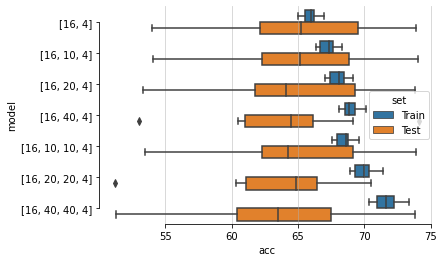

In [4]:
def evaluate_model_cross(model : torch.nn.Module, num_epochs, dfs = None, optim_kwargs = {"lr" : 1e-2, "weight_decay" : 1e-5}):
    """Evaluates a model, by training/testing in a "leave-one-participant-out" fashion

    Args:
        model (torch.nn.Module)
    """
    if dfs is None:
        dfs = preprocess_dataset( "condensed", 100, overlapping=False, )
    
    # Iterate over all candidates to leave out
    overall_acc_train = []
    overall_acc_test  = []
    for leave_out in range(1,11,1) :
        print("Person {} is left out".format(leave_out), end = "\r")
        model.reset_parameters()
        
        keys_test  = ["p{}_d1".format(leave_out),"p{}_d2".format(leave_out)]
        keys_train = [k  for k in dfs.keys() if k not in keys_test]
                 
        loader_train = create_dataloader({key : dfs[key] for key in keys_train},BATCH_SIZE,)
        loader_test  = create_dataloader({key : dfs[key] for key in keys_test} ,BATCH_SIZE,)
        
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_train,optim, verbose = False)
        acc_test = test_epoch(model,loader_test, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)

    print("Model {} Acc Mean:  Train: {:.2f}    Test: {:.2f}".format(model.description(), sum(overall_acc_train)/len(overall_acc_train), sum(overall_acc_test)/len(overall_acc_test) ))
    return (overall_acc_train, overall_acc_test)

def show_model_performances_cross(models : list):
    """Wraps the evaluate_model function to pass it multiple models at once and produce a nice plot from it

    Args:
        models (list): list of models
    """
    LOG_SAVES = {
        "[16, 4]":([65.95321773406191, 65.980336767553, 66.02518725360447, 64.98135456066464, 66.24847503187786, 66.43340873402923, 66.96340257171117, 65.05602838566334, 65.99993947597196, 65.36587072264628],
                   [65.88552298522087, 65.55762792368022, 64.79617098531111, 73.88929309727563, 61.251633942889484, 60.293907089955354, 53.96962292175746, 72.68240975207586, 64.83041515251624, 70.71215883813716]),
        "[16, 10, 4]": ([66.85754227114889, 67.21850637379768, 67.45172816120738, 66.3361115669041, 68.00261915428887, 67.73611139934007, 68.33582309275609, 66.60249297983705, 67.39845718750344, 66.3218431013132],
                        [65.60090517794445, 65.08844892899758, 65.25947233159644, 74.02672394876947, 60.17895885832873, 61.52654665677431, 54.06225544216058, 72.98038984747659, 64.50418456117167, 69.9424482446126]),
        "[16, 20, 4]": ([67.78862114320853, 67.91595811644571, 68.2811839855849, 67.03845350140173, 68.5635317227832, 68.49357710585842, 69.1599538139451, 67.27799565428478, 68.27371716571479, 67.11438226301834],
                        [67.05898820702446, 64.14893247297877, 64.07115742814703, 73.81884534987122, 61.05084425997548, 61.45235399013368, 53.30522415472825, 71.83675873034568, 62.64315604008369, 70.03542551814233]),
        "[16, 40, 4]" : ([68.4878758038557, 68.64060697227437, 69.11287817953404, 68.05957003995552, 69.22934831305786, 69.33986344864798, 70.14066123125727, 68.60185777226829, 69.34320425208807, 68.06867553329182],
                        [66.1374797326459, 66.15887211686612, 63.399193643458375, 74.12257908048366, 60.47812201005296, 61.063167896702986, 52.982607445738104, 65.50733172369118, 60.93354256139192, 69.11389127543634]),
        "[16, 10, 10, 4]" : ([68.28518720330354, 68.50406064115091, 68.77068743127506, 67.75425885956386, 68.78354068304787, 68.98679450197494, 69.58382348351942, 67.81134615034831, 68.68541811099006, 67.53136084739003],
                            [66.04299595236152, 64.38525967030039, 63.85188503524862, 73.86157595075586, 60.48890266416915, 61.70617100758847, 53.45535272227813, 72.36440727872328, 64.02929192820174, 70.16841832711523]),        
        "[16, 20, 20, 4]" : ([68.92280884097698, 69.30861854086086, 70.06936147710007, 69.14337564494708, 70.14522521280628, 70.44887625293129, 71.38052071927589, 69.941809949813, 70.71985078075997, 69.34983523748889],
                                [65.43643341226422, 64.84169553179412, 64.86808289911113, 70.47430966981949, 60.32315010713275, 61.56819868015151, 51.16669062335297, 66.78287497791649, 60.87572954520427, 67.51444678522249]),
        "[16, 40, 40, 4]" : ([70.3553563999591, 70.74403731331775, 71.76786428765287, 70.78184625611638, 71.56921804459455, 72.38978701032782, 73.33610124026654, 71.88101191084148, 72.62787076469358, 71.37134181749491], 
                            [65.19264192980205, 64.20801427230917, 62.69304222761889, 73.83732344755107, 59.98760224776638, 61.570801931612586, 51.2561289189146, 68.28337553736529, 59.964486290056165, 68.67842809561358])
        }
    
    logging = pd.DataFrame(columns= ["model", "acc", "set"])
    
    for mod in models:
        print("Model: " + mod.description())
        if mod.description() in LOG_SAVES:
            overall_acc_train, overall_acc_test = LOG_SAVES[mod.description()]
            
        else:
            overall_acc_train, overall_acc_test = evaluate_model_cross(mod,5,dfs)
            print(overall_acc_train)
            print(overall_acc_test)
            print()
        logging = pd.concat([logging, 
        
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_train],
                "acc" : overall_acc_train,
                "set" : ["Train" for _ in overall_acc_train]
            }),
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_test],
                "acc" : overall_acc_test,
                "set" : ["Test" for _ in overall_acc_test]
            })
        ])
    
    sns.boxplot(data=logging, x="acc", y="model", hue="set")
    #sns.stripplot(data=logging, x="acc", y="model", hue="set")
    sns.despine(trim = True)
    
    plt.grid(axis = "x", alpha = 0.6)
    plt.show()
    

show_model_performances_cross(models = [
        Linear_Model(num_hidden=[]),
        Linear_Model(num_hidden=[10]),
        Linear_Model(num_hidden=[20]),
        Linear_Model(num_hidden=[40]),
        Linear_Model(num_hidden=[10,10]),
        Linear_Model(num_hidden=[20,20]),
        Linear_Model(num_hidden=[40,40]),
    ])

Model: [16, 4]
Model: [16, 10, 4]
Model: [16, 20, 4]
Model: [16, 40, 4]
Model: [16, 10, 10, 4]
Model: [16, 20, 20, 4]
Model: [16, 40, 40, 4]


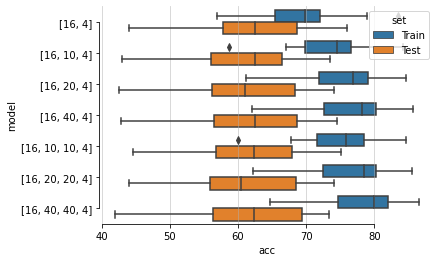

In [6]:
def model_in_person_accuracy(model : torch.nn.Module, num_epochs, dfs = None, optim_kwargs = {"lr" : 1e-2, "weight_decay" : 1e-5}):
    """Evaluates a model, by training/testing on one day of a person and predicting the other day.
    Per person has to experiments: d1→d2 and d2→d1

    Args:
        model (torch.nn.Module)
    """
    if dfs is None:
        dfs = preprocess_dataset( "condensed", 100, overlapping=False, )
    
    # Iterate over all candidates 
    overall_acc_train = []
    overall_acc_test  = []
    for person in range(1,11,1) :
        print("Person {}".format(person), end = "\r")
       
        loader_d1  = create_dataloader({"p{}_d1".format(person) : dfs["p{}_d1".format(person)]},BATCH_SIZE,)
        loader_d2  = create_dataloader({"p{}_d2".format(person) : dfs["p{}_d2".format(person)]},BATCH_SIZE,)
        
        
        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_d1,optim, verbose = False)
        acc_test = test_epoch(model,loader_d2, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        
        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_d2,optim, verbose = False)
        acc_test = test_epoch(model,loader_d1, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        

    print("Model {} Acc Mean:  Train: {:.2f}    Test: {:.2f}".format(model.description(), sum(overall_acc_train)/len(overall_acc_train), sum(overall_acc_test)/len(overall_acc_test) ))
    return (overall_acc_train, overall_acc_test)

def show_model_performances_in_person(models : list):
    """Wraps the model_in_person_accuracy function to pass it multiple models at once and produce a nice plot from it

    Args:
        models (list): list of models
    """
    LOG_SAVES = {
        "[16, 4]" : ([71.80273321449792, 71.50089338892198, 71.31043104070005, 70.92836061175208, 66.84658641794078, 64.35247983821245, 73.6212229359981, 78.92232770035234, 65.86945094853537, 58.78589311655797, 61.1509444058002, 64.86856447565211, 56.906886451876574, 65.60704941204776, 77.26888741752094, 72.44197927309882, 66.79524268723883, 68.77019316697601, 70.9268826932692, 83.40548340548341],
                    [63.245063453520864, 68.47058823529412, 66.10991861193095, 64.21136139625455, 57.58009223863665, 66.89852977709523, 76.05422024731256, 69.24101832024743, 51.03699811454888, 50.85535432694604, 61.636543385130174, 57.8388356787415, 47.294818200956364, 43.985423336284995, 71.7583807716635, 72.56786684627502, 60.11892486423317, 57.9786012765762, 68.9731415537867, 58.115282969453105]),
        "[16, 10, 4]" : ([76.03802733214498, 75.48678242543639, 74.86116787268313, 72.87809677130846, 69.23598093904559, 67.06044836855995, 76.51439448013323, 81.52112928925695, 77.65566015195681, 74.31768305875808, 67.71897907860239, 70.87378640776699, 58.637013827395954, 69.70316682205046, 76.78714125893286, 75.38802121344816, 69.94305919088947, 72.75039527050251, 78.22432799219067, 84.1223292836196],
                        [65.64575983873185, 68.18775995246583, 62.08299794293891, 65.95427554871746, 59.90332207068341, 65.77384313105536, 73.48010502928702, 69.76445396145611, 56.21735233208667, 64.2351985473312, 57.192831250475294, 54.77286104125422, 46.37755255481038, 43.00796948436755, 72.1597820269547, 70.53814014018585, 62.95112394308104, 55.41396886623502, 54.29874784713494, 61.78900502368991]),
        "[16, 20, 4]" : ([79.0017825311943, 77.4247491638796, 77.18104671009928, 75.60370270995439, 70.65651889157388, 68.14314252595753, 80.29502736140853, 83.70923943535537, 80.49170927509915, 78.41313015794516, 71.02306169404461, 72.92453547618443, 61.113003201416795, 72.15722835403446, 78.5976848786502, 76.43166447720527, 70.87753134040501, 73.55812194954287, 79.28382657555773, 84.60410557184751],
                    [66.95606359096531, 71.59120617944147, 66.66443073070387, 69.3535591509003, 60.73692258366834, 64.0935883827548, 74.10399694786688, 71.51320485367594, 58.59734800482181, 61.29402207674296, 56.0293036578874, 56.174755203595694, 47.556464467234065, 42.53797425243512, 71.37157592565562, 68.02210096120916, 58.84031071698632, 55.21651283464205, 52.75799469347856, 57.991476393419205]),
        "[16, 40, 4]" : ([79.41770647653, 78.07761029917076, 78.22919922109767, 76.48466147929524, 71.20079495923576, 69.02360223937653, 81.99619319533666, 84.34435243160753, 81.69589525493382, 80.15330881216579, 72.02365027556317, 73.80161727800451, 62.06321095293236, 72.75269916694235, 79.8077581679947, 78.15647350751715, 71.77297148367543, 75.20450952086341, 80.35522963738958, 85.58627752176139],
                    [69.71640628579281, 69.87759952465835, 65.85725784813523, 66.51200807750558, 62.347399314375906, 62.85146457688746, 74.45633878677708, 72.07946704734714, 58.51698451457361, 62.69173794619392, 57.922887779157904, 56.56535930226336, 48.85266608523052, 42.807029493903684, 71.90921033425776, 68.23215141898217, 53.952705025091085, 55.599944895991186, 56.10017222920449, 58.050998785743204]),
        "[16, 10, 10, 4]" : ([78.37908496732025, 76.50616209282082, 75.08954972714379, 75.17440300509793, 70.64296845005533, 67.78799911214146, 79.24577682607661, 83.14369712067146, 79.69130787977254, 77.82585849843909, 69.93151051420622, 71.8243808461558, 59.951638171786655, 71.86250037592853, 77.98351560537911, 76.84522940689924, 70.4642512742802, 73.76091290300405, 78.67907906954596, 84.6925475957734],
                    [68.66037476519907, 70.84254307783719, 62.51006171183258, 67.13945717239224, 62.325202851012406, 64.72142550644774, 75.06003276554681, 71.49417083035927, 59.635891571106235, 56.5847947627467, 56.87089660067429, 55.21697255069827, 48.843643800186456, 44.57802602002589, 71.09424414927261, 67.76867051759172, 63.387640063243275, 62.29967396794783, 54.56407391891263, 57.129592152567795]),
        "[16, 20, 20, 4]" : ([79.62448009506832, 78.75108810189215, 78.76529557420007, 76.67918790805831, 72.18320196933084, 68.98660813377069, 81.45372353081133, 84.67425211517315, 82.01844507096095, 80.34185392390195, 72.44100807961902, 74.22494866790032, 62.18922416729106, 72.45496376048841, 78.63878170734492, 78.45083442806403, 71.75919548147127, 75.00515570220664, 80.14571081640914, 85.46757901596611],
                    [68.5756173546525, 69.70172311348783, 66.53251050889902, 65.7138735966536, 58.99573334648679, 62.58948937419544, 74.06808949931552, 72.30549607423269, 56.15862516613607, 57.31112916328188, 58.50084919769829, 54.98689068435978, 46.65122853448017, 43.99223486138546, 68.3939084318591, 69.60661202310555, 57.34515707706056, 55.25554484088717, 54.39649955778988, 61.91995428680269]),
        "[16, 40, 40, 4]" : ([81.28104575163398, 80.07284555825353, 79.823064163281, 77.77926840175297, 72.6619842363197, 70.31839593558094, 83.59743040685224, 85.94223389214301, 83.71481817747409, 82.99384910209254, 73.84022687142169, 75.90559963497174, 64.71629997956543, 74.91203272082043, 81.01326514303979, 80.07346859339269, 74.03682784589245, 76.59998625146078, 81.74091093069212, 86.54284783317041],
                    [70.28221926971182, 70.2293523469994, 65.84607816832127, 64.24742168906411, 58.75897107060941, 60.76695498995009, 73.41502277878767, 72.21508446347846, 54.20208326893952, 62.366798872270266, 57.49702147075971, 53.97292525014714, 48.01660100448107, 41.92493699339282, 69.1091324867416, 70.85778214114478, 57.10799477555509, 62.94714607154337, 51.69436298468556, 62.21280445703674]),       
        }
    
    logging = pd.DataFrame(columns= ["model", "acc", "set"])
    
    for mod in models:
        print("Model: " + mod.description())
        if mod.description() in LOG_SAVES:
            overall_acc_train, overall_acc_test = LOG_SAVES[mod.description()]
            
        else:
            overall_acc_train, overall_acc_test = model_in_person_accuracy(mod,5,dfs)
            print(overall_acc_train)
            print(overall_acc_test)
            print()
        logging = pd.concat([logging, 
        
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_train],
                "acc" : overall_acc_train,
                "set" : ["Train" for _ in overall_acc_train]
            }),
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_test],
                "acc" : overall_acc_test,
                "set" : ["Test" for _ in overall_acc_test]
            })
        ])
    
    sns.boxplot(data=logging, x="acc", y="model", hue="set")
    #sns.stripplot(data=logging, x="acc", y="model", hue="set")
    sns.despine(trim = True)
    
    plt.grid(axis = "x", alpha = 0.6)
    plt.show()
    

show_model_performances_in_person(models = [
        Linear_Model(num_hidden=[]),
        Linear_Model(num_hidden=[10]),
         Linear_Model(num_hidden=[20]),
         Linear_Model(num_hidden=[40]),
         Linear_Model(num_hidden=[10,10]),
         Linear_Model(num_hidden=[20,20]),
         Linear_Model(num_hidden=[40,40]),
    ])

In [10]:
def model_calibration_accuracy(model : torch.nn.Module, num_epochs, dfs = None, optim_kwargs = {"lr" : 1e-2, "weight_decay" : 1e-5}):
    """Evaluates a model, by training it on the entire dataset except one. This includes also the other day by the same person. 
    Per person has to experiments: d1→d2 and d2→d1

    Args:
        model (torch.nn.Module)
    """
    if dfs is None:
        dfs = preprocess_dataset( "condensed", 100, overlapping=False, )
    
    # Iterate over all candidates 
    overall_acc_train = []
    overall_acc_test  = []
    for person in range(1,11,1) :
        print("Person {}".format(person), end = "\r")
       
        loader_d1  = create_dataloader({"p{}_d1".format(person) : dfs["p{}_d1".format(person)]},BATCH_SIZE,)
        loader_d2  = create_dataloader({"p{}_d2".format(person) : dfs["p{}_d2".format(person)]},BATCH_SIZE,)
        
        keys_not_d1 = [k  for k in dfs.keys() if k != "p{}_d1"]
        keys_not_d2 = [k  for k in dfs.keys() if k != "p{}_d2"]
                
        loader_not_d1 = create_dataloader({key : dfs[key] for key in keys_not_d1},BATCH_SIZE,)
        loader_not_d2 = create_dataloader({key : dfs[key] for key in keys_not_d2},BATCH_SIZE,)
        

        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_not_d2,optim, verbose = False)
        acc_test = test_epoch(model,loader_d2, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        
        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_not_d1,optim, verbose = False)
        acc_test = test_epoch(model,loader_d1, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        

    print("Model {} Acc Mean:  Train: {:.2f}    Test: {:.2f}".format(model.description(), sum(overall_acc_train)/len(overall_acc_train), sum(overall_acc_test)/len(overall_acc_test) ))
    return (overall_acc_train, overall_acc_test)

def show_model_calibration(models : list):
    """Wraps the model_in_person_accuracy function to pass it multiple models at once and produce a nice plot from it

    Args:
        models (list): list of models
    """
    LOG_SAVES = {
        "[16, 4]" : ([71.69578134284016, 71.37948412516609, 71.32725917734452, 70.89258563634738, 66.81722712798393, 64.35987865933362, 73.55222460147513, 78.84153594111179, 65.62574664309265, 58.42425741044107, 61.188399593343675, 64.93193743821136, 56.787684762618355, 65.86568824997744, 77.30541793191625, 72.44684474285992, 66.89397070303531, 68.77363030178043, 70.86736030094521, 83.38220918866081],
                    [62.30127823338067, 68.52287581699346, 65.9042125033539, 64.21376541577519, 57.178089624386516, 66.8398111971815, 75.7714490899706, 69.13395193909112, 50.8144530646308, 49.115974578295976, 61.8798955613577, 57.70506715180053, 46.69934738804848, 43.55289149240515, 71.69756239964968, 72.51535423183178, 59.88863683233656, 57.25536116085779, 69.78773914257785, 58.10814028237423])
        "[16, 10, 4]" : ()
        }
    
    logging = pd.DataFrame(columns= ["model", "acc", "set"])
    
    for mod in models:
        print("Model: " + mod.description())
        if mod.description() in LOG_SAVES:
            overall_acc_train, overall_acc_test = LOG_SAVES[mod.description()]
            
        else:
            overall_acc_train, overall_acc_test = model_in_person_accuracy(mod,5,dfs)
            print(overall_acc_train)
            print(overall_acc_test)
            print()
        logging = pd.concat([logging, 
        
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_train],
                "acc" : overall_acc_train,
                "set" : ["Train" for _ in overall_acc_train]
            }),
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_test],
                "acc" : overall_acc_test,
                "set" : ["Test" for _ in overall_acc_test]
            })
        ])
    
    sns.boxplot(data=logging, x="acc", y="model", hue="set")
    #sns.stripplot(data=logging, x="acc", y="model", hue="set")
    sns.despine(trim = True)
    
    plt.grid(axis = "x", alpha = 0.6)
    plt.show()
    

show_model_calibration(models = [
        Linear_Model(num_hidden=[]),
        Linear_Model(num_hidden=[10]),
         Linear_Model(num_hidden=[20]),
         Linear_Model(num_hidden=[40]),
         Linear_Model(num_hidden=[10,10]),
         Linear_Model(num_hidden=[20,20]),
         Linear_Model(num_hidden=[40,40]),
    ])

Model: [16, 4]
Model [16, 4] Acc Mean:  Train: 69.07    Test: 61.44
[71.69578134284016, 71.37948412516609, 71.32725917734452, 70.89258563634738, 66.81722712798393, 64.35987865933362, 73.55222460147513, 78.84153594111179, 65.62574664309265, 58.42425741044107, 61.188399593343675, 64.93193743821136, 56.787684762618355, 65.86568824997744, 77.30541793191625, 72.44684474285992, 66.89397070303531, 68.77363030178043, 70.86736030094521, 83.38220918866081]
[62.30127823338067, 68.52287581699346, 65.9042125033539, 64.21376541577519, 57.178089624386516, 66.8398111971815, 75.7714490899706, 69.13395193909112, 50.8144530646308, 49.115974578295976, 61.8798955613577, 57.70506715180053, 46.69934738804848, 43.55289149240515, 71.69756239964968, 72.51535423183178, 59.88863683233656, 57.25536116085779, 69.78773914257785, 58.10814028237423]

Model: [16, 10, 4]
